In [1]:
import os
import sys
sys.path.append(r"C:\Users\Cristhian\Documents\github\QuantumGRN")
import numpy as np
import pandas as pd

In [2]:
filename="../../dataset/expr_matrix_pearsonresidual_7.txt"
df = pd.read_csv(filename, delimiter='\t')
df = df.set_index('genes').T
df.head()

genes,AICDA,IRF4,PAX5,PRDM1,REL,RELA
X1,-0.744255,-1.389371,0.869163,-0.639366,0.499583,-0.558294
X2,-0.574980,0.760179,1.470277,-0.493802,0.178566,-0.431103
X3,-0.756529,0.670392,5.327456,-0.649925,1.276864,1.188840
X4,1.000327,-1.152912,-0.541244,-0.529274,0.039775,-0.462092
X5,-0.505078,-0.946417,-0.443544,-0.433726,-0.800315,-0.378630


In [3]:
from qscgrn import *

ncells, ngenes = df.shape
df = qsc_order_gene(df)
genes = df.columns.to_list()
p_obs = qsc_distribution(df)
activation = qsc_activation_ratios(df)

2022-11-25 17:39:43 | I | The dataframe genes are ordered
2022-11-25 17:39:43 | I | The observed probability `p_obs` is calculated
2022-11-25 17:39:43 | I | Activation ratios are computed


2022-11-25 17:39:43 | I | Plotting the Observed distribution in a barplot and exporting to p_obs.svg file.


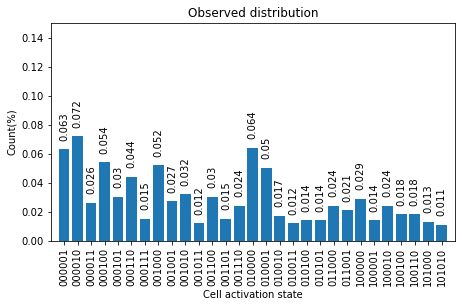

In [4]:
mask = mini_hist(ngenes, p_obs, limit=0.01, ymax=0.15,
                 title="Observed distribution",
                 filename="p_obs.svg")

In [5]:
theta = theta_init(genes, activation_ratios=activation)
edges = edges_init(genes)
qgrn = model(ncells, genes, theta, edges, p_obs, epochs=4000, learning_rate=0.05, save_theta=True)

2022-11-25 17:39:44 | I | Theta series is initialized using zeros as method with activation values
2022-11-25 17:39:44 | I | Edges for the QuantumGRN and quantum circuit are created for 6 genes
2022-11-25 17:39:44 | I | The QuantumGRN model is been initialized with 6 genes and 28208 cells


In [6]:
p_init = qgrn.output_probabilities(drop_zero=True).reshape(2**ngenes,)

2022-11-25 17:39:44 | I | Plotting the Comparison of distributions in a barplot and exporting to comparison_obs_init.svg file.


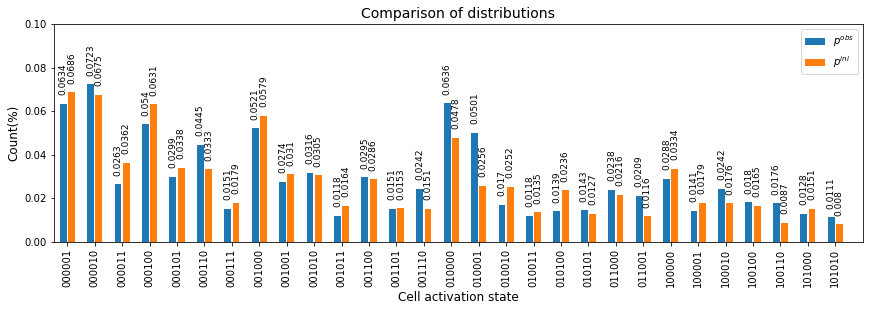

In [7]:
comparison_hist(ngenes, p_obs, p_init, limit=0.01, ymax=0.10, mask=mask,
                filename="comparison_obs_init.svg", tags=["p^{obs}", "p^{ini}"])

In [8]:
qgrn.train()

2022-11-25 17:39:45 | I | Starting the optimization for the QuantumGRN
1087/4000 [============>.....................................] - 94s 87ms/step
2022-11-25 17:41:19 | I | Optimization completed!!.. Due to threshold reached


In [9]:
p_out = qgrn.p_out.reshape(2**ngenes,)

2022-11-25 17:41:19 | I | Plotting the Comparison of distributions in a barplot and exporting to comparison_obs_out.svg file.


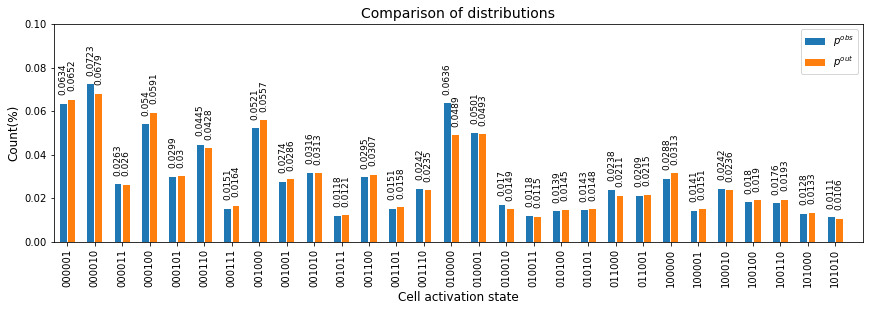

In [10]:
comparison_hist(ngenes, p_obs, p_out, limit=0.01, ymax=0.10, mask=mask,
                filename="comparison_obs_out.svg")

In [11]:
p_qiskit = qgrn.run_qiskit(filename="circuit_qscgrn.svg")

2022-11-25 17:41:23 | I | Drawing the quantum circuit of the qscGRN model and saving to circuit_qscgrn.svg


2022-11-25 17:41:23 | I | Plotting the Comparison of distributions in a barplot and exporting to comparison_obs_qiskit.svg file.


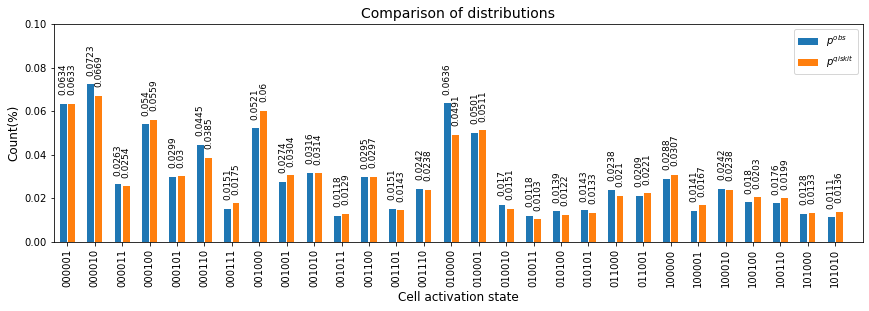

In [12]:
comparison_hist(ngenes, p_obs, p_qiskit, limit=0.01, ymax=0.1, mask=mask,
                filename="comparison_obs_qiskit.svg", tags=["p^{obs}", "p^{qiskit}"])

In [13]:
qgrn.export_training_theta("evolution_theta.csv")

2022-11-25 17:41:24 | I | Theta values during optimization are exported to evolution_theta.csv


In [14]:
from qscgrn import draw_network

draw_network(genes, edges, qgrn.theta, filename="network_qscgrn.svg")

2022-11-25 17:41:24 | I | Drawing the network representation of the qscGRN model and exporting to network_qscgrn.svg file.


In [15]:
import matplotlib as mpt
import matplotlib.pyplot as plt

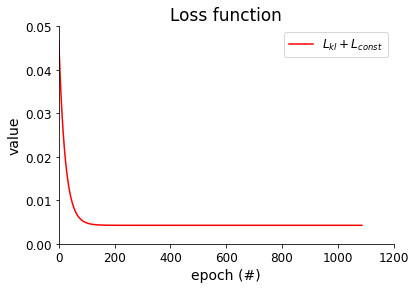

In [17]:
plt.figure()
plt.plot(qgrn.loss, 'r', label='$L_{kl} + L_{const}$')

plt.title("Loss function", fontsize=17)
plt.xlabel("epoch (#)", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.xticks([0, 200, 400, 600, 800, 1000, 1200], fontsize=12)
plt.yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05], fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(fontsize=12)
plt.xlim([0, 1200])
plt.ylim([0, 0.05])

plt.savefig("loss_function.svg", transparent=True, bbox_inches="tight", facecolor ='w', dpi=700)

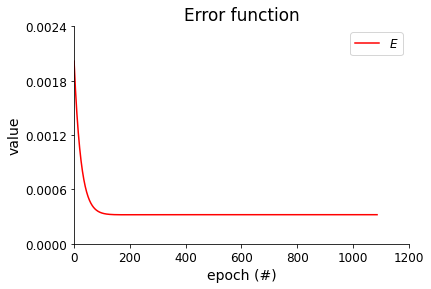

In [18]:
plt.figure()
plt.plot(qgrn.error, 'r', label='$E$')

plt.title("Error function", fontsize=17)
plt.xlabel("epoch (#)", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.xticks([0, 200, 400, 600, 800, 1000, 1200], fontsize=12)
plt.yticks([0, 0.0006, 0.0012, 0.0018, 0.0024], fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(fontsize=12)
plt.xlim([0, 1200])
plt.ylim([0, 0.0024])

plt.savefig("error_function.svg", transparent=True, bbox_inches="tight", facecolor ='w', dpi=700)

In [19]:
with open("results/p_obs.npy", "wb") as f:
    np.save(f, p_obs)
    
with open("results/p_out.npy", "wb") as f:
    np.save(f, p_out)
    
with open("results/p_qiskit.npy", "wb") as f:
    np.save(f, p_qiskit)

In [20]:
with open("results/loss.npy", "wb") as f:
    np.save(f, qgrn.loss)
    
with open("results/error.npy", "wb") as f:
    np.save(f, qgrn.error)

In [21]:
qgrn.theta.to_csv("results/theta.csv")